<a href="https://colab.research.google.com/github/gh0st-kid/TimeSeries_Analysis_and_Prediction/blob/main/TS_model_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install prophet

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import (mean_squared_error, mean_absolute_error,
                             mean_absolute_percentage_error)
import prophet
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot, plot_cross_validation_metric
import warnings
import logging

In [16]:
warnings.filterwarnings("ignore")
logging.getLogger('prophet').setLevel(logging.ERROR)
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

In [17]:
def check_versions():
  print(f'Pandas версия: {pd.__version__}')
  print(f'Numpy версия: {np.__version__}')
  print(f'Matplotlib версия: {plt.matplotlib.__version__}')
  print(f'Seaborn версия: {sns.__version__}')
  print(f'Scikit-learn версия: {sklearn.__version__}')
  print(f'Prophet версия: {prophet.__version__}')
  print(f'Библиотеки успешно импортированы.')

check_versions()

Pandas версия: 2.1.4
Numpy версия: 1.26.4
Matplotlib версия: 3.7.1
Seaborn версия: 0.13.1
Scikit-learn версия: 1.5.2
Prophet версия: 1.1.5
Библиотеки успешно импортированы.


In [18]:
def load_and_prepare_data(file_path):
  """
  Загружает и подготавливает данные из CSV файла.

  Аргументы:
  file_path : str
      Путь к CSV файлу с данными.

  Возвращает:
  pandas.DataFrame
      Подготовленный датафрейм с данными, где:
    - Удалены пробелы из названий столбцов.
    - Столбец 'year' преобразован в формат даты и установлен в качестве индекса.
    - Все числовые столбцы преобразованы в тип float.
    - Данные отсортированы по году.
  """
  df = pd.read_csv(file_path, delimiter=';')
  df.columns = df.columns.str.strip()
  df['year'] = pd.to_datetime(df['year'], format='%Y') + pd.offsets.YearEnd(0)
  numeric_columns = df.columns[1:]
  df[numeric_columns] = df[numeric_columns].astype(float)
  df.sort_values('year', inplace=True)
  df.set_index('year', inplace=True)
  return df

df = load_and_prepare_data('/content/Data_new.csv')

In [19]:
df.head()

,zan(cfo),zan(szfo),zan(ufo),zan(skfo),zan(pfo),zan(uralfo),zan(sfo),zan(dfo),bezr(cfo),bezr(szfo),...,bezr(sfo),bezr(dfo),srd(cfo),srd(szfo),srd(ufo),srd(skfo),srd(pfo),srd(uralfo),srd(sfo),srd(dfo)
year,,,,,,,,,,,,,,,,,,,,,
2000-12-31,18014.45,6684.28,5850.76,2603.97,14242.84,5720.02,7933.75,4020.35,1516.38,710.35,...,1124.00,628.32,3231.0,2269.0,1592.0,1130.0,1726.0,2744.0,1933.0,2498.0
2001-12-31,18209.86,6788.93,5846.68,2653.35,14225.29,5642.28,7817.38,3939.14,1165.34,556.96,...,929.68,521.56,4300.0,3084.0,2165.0,1441.0,2319.0,3820.0,2576.0,3304.0
2002-12-31,18596.99,6911.31,6071.07,2762.83,14457.40,5733.71,8054.44,4071.13,1000.25,460.45,...,868.63,435.51,5436.0,4010.0,2898.0,1922.0,3035.0,4791.0,3373.0,4391.0
2003-12-31,18609.92,6873.34,5816.19,2765.72,14280.29,5974.66,7972.59,4046.69,1002.11,516.25,...,972.79,455.21,7211.0,5403.0,3747.0,2532.0,3917.0,6110.0,4351.0,5788.0
2004-12-31,18912.54,6970.38,6156.19,2769.92,14378.12,5938.58,8179.20,4013.68,930.45,443.38,...,853.29,442.81,8992.0,6938.0,4565.0,3466.0,4787.0,7413.0,5267.0,7047.0


In [20]:
def prepare_data_prophet(df, variable_name):
    '''
    Подготовка данных для модели Prophet, включая преобразование формата данных.

    Аргументы:
        df : pandas.DataFrame
            Исходный датафрейм, содержащий временной ряд.
        variable_name : str
            Название переменной (столбца) в датафрейме df для анализа.

    Возвращает:
        df_prophet : pandas.DataFrame
            Датафрейм, подготовленный для использования в модели Prophet, с
            переименованными столюцами.
    '''
    df_prophet = df.reset_index().rename(columns={'year': 'ds', variable_name: 'y'})
    return df_prophet

In [21]:
def train_prophet_model(df_prophet):
    '''
    Обучение модели Prophet на подготовленных данных.

    Аргументы:
        df_prophet : pandas.DataFrame
            Датафрейм с временным рядом, подготовленный для модели Prophet.

    Возвращает:
        model : Prophet
            Обученная модель Prophet.
    '''
    model = Prophet()
    model.fit(df_prophet)
    return model

In [22]:
def forecast_and_plot_prophet(model, periods=3):
    '''
    Построение прогноза с использованием модели Prophet и визуализация рузультатов.

    Аргументы:
        model : Prophet
            Обученная модель Prophet.
        periods : int, optional
            Количество периодов для прогнозирования(по умолчанию 3).

    Возвращает:
        forecast : pandas.DataFrame
            Датафрейм с прогнозируемыми значениями и доверительными интервалами.
    '''
    future = model.make_future_dataframe(periods=periods, freq='Y')
    forecast = model.predict(future)
    fig = model.plot(forecast)
    return forecast

In [23]:
def evaluate_forecast_prophet(model):
    '''
    Оценка качетва прогноза модели Prophet с использованием кросс-валидации.

    Аргументы:
        model : Prophet
            Обученная модель Prophet.

    Возвращает:
        df_p : pandas.DataFrame
            Датафрейм с метриками оценки качества прогноза.
    '''
    df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='1095 days')
    df_p = performance_metrics(df_cv)
    return df_p

In [24]:
def prophet_forecast(df, variable_name):
    '''
    Пайплайн для выполнения всех шагов анализа с использованием модели Prophet,
    включая подоготовку данных, обучение, прогнозирование и оценку.

    Аргументы:
        df : pandas.DataFrame
            Исходный датафрейм, содержащий временной ряд.
        variable_name : str
            Название переменной (столбца) в датафрейме df для анализа.

    Возвращает:
        forecast : pandas.DataFrame
            Датафрейм с прогнозируемыми значениями.
        df_p : pandas.DataFrame
            Датафрейм с метриками оценки качества прогноза.
    '''
    df_prophet = prepare_data_prophet(df, variable_name)

    # Проверка содержимого df_prophet
    print(df_prophet.head())  # Добавлено для отладки

    model = train_prophet_model(df_prophet)
    forecast = forecast_and_plot_prophet(model)
    df_p = evaluate_forecast_prophet(model)

    # Вывод числовых значений прогнозов
    print('\nЧисловые значения прогнозов:')
    print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3))

    # Печать результатов оценки качества прогноза
    print('\nОценка качества прогноза')
    print(df_p.head())

          ds  zan(cfo)  zan(szfo)  zan(ufo)  zan(skfo)  zan(pfo)  zan(uralfo)  \
0 2000-12-31  18014.45    6684.28   5850.76    2603.97  14242.84      5720.02   
1 2001-12-31  18209.86    6788.93   5846.68    2653.35  14225.29      5642.28   
2 2002-12-31  18596.99    6911.31   6071.07    2762.83  14457.40      5733.71   
3 2003-12-31  18609.92    6873.34   5816.19    2765.72  14280.29      5974.66   
4 2004-12-31  18912.54    6970.38   6156.19    2769.92  14378.12      5938.58   

   zan(sfo)  zan(dfo)  bezr(cfo)  ...  bezr(sfo)  bezr(dfo)       y  \
0   7933.75   4020.35    1516.38  ...    1124.00     628.32  3231.0   
1   7817.38   3939.14    1165.34  ...     929.68     521.56  4300.0   
2   8054.44   4071.13    1000.25  ...     868.63     435.51  5436.0   
3   7972.59   4046.69    1002.11  ...     972.79     455.21  7211.0   
4   8179.20   4013.68     930.45  ...     853.29     442.81  8992.0   

   srd(szfo)  srd(ufo)  srd(skfo)  srd(pfo)  srd(uralfo)  srd(sfo)  srd(dfo)  
0     2

  0%|          | 0/35 [00:00<?, ?it/s]


Числовые значения прогнозов:
           ds          yhat    yhat_lower    yhat_upper
23 2023-12-31  59234.766200  57817.733963  60630.474358
24 2024-12-31  61699.620147  60403.980024  62998.983272
25 2025-12-31  64782.097748  63390.570645  66175.497244

Оценка качества прогноза
   horizon           mse         rmse          mae      mape     mdape  \
0 143 days  2.925411e+06  1710.383307  1539.907542  0.101283  0.078742   
1 148 days  3.003897e+06  1733.175512  1588.004547  0.096457  0.076265   
2 153 days  2.396096e+06  1547.932663  1428.073061  0.069592  0.066198   
3 158 days  2.451655e+06  1565.776043  1470.402927  0.067816  0.066198   
4 164 days  2.246452e+06  1498.816912  1397.727234  0.057637  0.044577   

      smape  coverage  
0  0.110254       0.0  
1  0.105147       0.0  
2  0.072929       0.0  
3  0.071096       0.0  
4  0.060010       0.0  


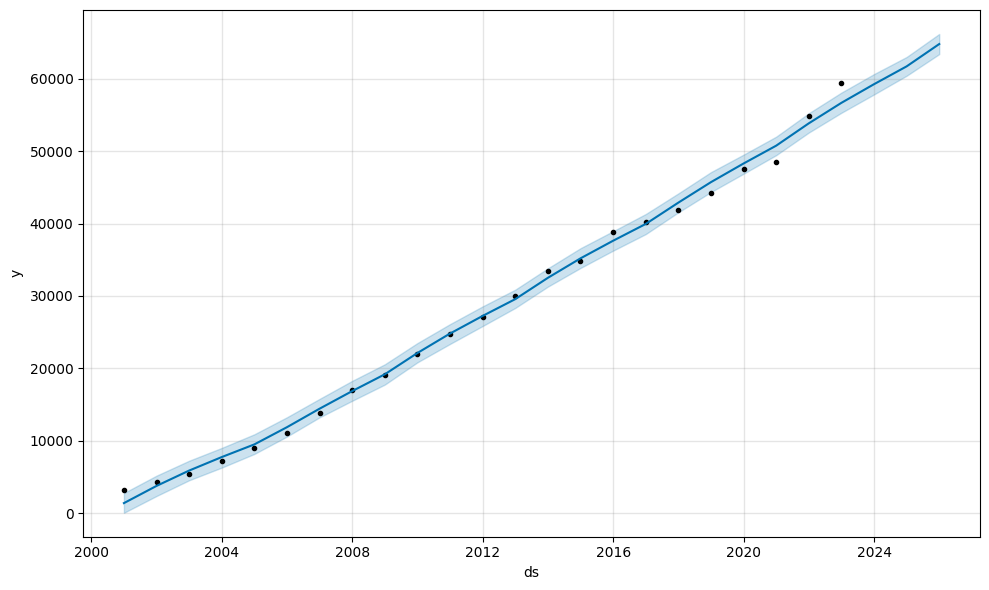

In [25]:
prophet_forecast(df, 'srd(cfo)')